In [85]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import *
import requests
from sklearn.metrics import *
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from CONSTANTS import *
from audioread.ffdec import ReadTimeoutError
from functions import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')

In [102]:
start = datetime.now()
end = datetime.strptime('01/01/2008', '%m/%d/%Y')
df, coin = prices(COIN, start=end, end=start)
df.sort_values('time', ascending=False, inplace=True)
df.set_index('time', inplace=True)
index = df.index

In [103]:
fgi = get_fgi_data(df)
df = pd.merge(df, fgi, left_on='time', right_on='timestamp', how='left')
df['timestamp'].fillna(pd.to_datetime('1970-01-01'), inplace=True)
val = df[df['value'].isna() == False]['value'].values[0] # Last known FGI value
fgiClassification = df[df['value_classification'].isna() == False]['value_classification'].values[0] # Last known FGI classification
df['value'].fillna(val, inplace=True)
df['value_classification'].fillna(fgiClassification, inplace=True)
df.index = index

## Crypto market collector

# Steps to train LSTM to predict buy and sell



1.   Obtain additional metrics

* Moving averages (short-term and long-term)
* Relative Strength Index (RSI)
* Moving Average Convergence Divergence (MACD)
* Bollinger Bands
* Volume indicators

2.   Model Approaches

* Classification
  * label buys, sells, holds (1, -1, 0) based on market data
  * predict each label

* Regression
  * predict return over time
    * look at windows of time to find optimal profits
  * identify buy and sell periods



### Generate Metrics

In [105]:
# ----------------------------
# 1. Moving Averages (SMA & EMA)
# ----------------------------
# Short-term SMA (20 periods) and long-term SMA (50 periods)
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()

# Exponential Moving Averages (optional, can be used in place of or along with SMAs)
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean()

# ----------------------------
# 2. Relative Strength Index (RSI)
# ----------------------------

df['RSI'] = compute_rsi(df['close'], window=14)

# ----------------------------
# 3. Moving Average Convergence Divergence (MACD)
# ----------------------------
# Calculate the 12-period and 26-period EMA of the closing price
df['EMA_12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['close'].ewm(span=26, adjust=False).mean()

# MACD line: difference between the 12-EMA and 26-EMA
df['MACD'] = df['EMA_12'] - df['EMA_26']

# Signal line: 9-period EMA of the MACD line
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']


df['BB_Middle'] = df['SMA_20']  # Middle band is the 20-period SMA
df['BB_STD'] = df['close'].rolling(window=20).std()
df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_STD']
df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_STD']
df['Volume_MA_20'] = df['volume'].rolling(window=20).mean()

df['daily_return'] = df['close'].pct_change()  # percentage change in closing price
df['direction'] = np.where(df['daily_return'] > 0, 1, -1)  # +1 for up days, -1 for down days
df.loc[df['daily_return'].isna(), 'direction'] = 0  # set initial value to 0
df['OBV'] = (df['volume'] * df['direction']).fillna(0).cumsum()

df.drop(columns=['daily_return', 'direction'], inplace=True)

,low,high,open,close,volume,change,pct_change,timestamp,value,value_classification,...,EMA_26,MACD,MACD_Signal,MACD_Hist,BB_Middle,BB_STD,BB_Upper,BB_Lower,Volume_MA_20,OBV
time,,,,,,,,,,,,,,,,,,,,,
2015-07-24,276.43,291.52,277.23,289.12,7362.469083,11.89,4.288858,1970-01-01,50.0,Neutral,...,275.731790,11.022946,11.627888,-0.604942,281.6625,10.125222,301.912943,261.412057,5292.043713,-3.757733e+06
2015-07-23,276.28,279.75,277.96,277.39,5306.919575,-0.57,-0.205065,1970-01-01,50.0,Neutral,...,275.854620,9.459387,11.194188,-1.734801,282.1850,9.580474,301.345949,263.024051,5239.876891,-3.763040e+06
2015-07-22,275.01,278.54,277.33,277.89,4687.909383,0.56,0.201926,1970-01-01,50.0,Neutral,...,276.005389,8.166463,10.588643,-2.422180,282.4800,9.337792,301.155584,263.804416,5184.465121,-3.758352e+06
2015-07-21,276.85,281.27,279.96,277.32,4943.559434,-2.64,-0.942992,1970-01-01,50.0,Neutral,...,276.102768,7.014953,9.873905,-2.858952,283.0885,8.508770,300.106039,266.070961,5157.713985,-3.763295e+06
2015-07-20,277.37,280.00,277.98,280.00,782.883420,2.02,0.726671,1970-01-01,50.0,Neutral,...,276.391452,6.246620,9.148448,-2.901828,283.7070,7.740892,299.188784,268.225216,4944.509312,-3.762512e+06


### Plot the Bollinger Bands

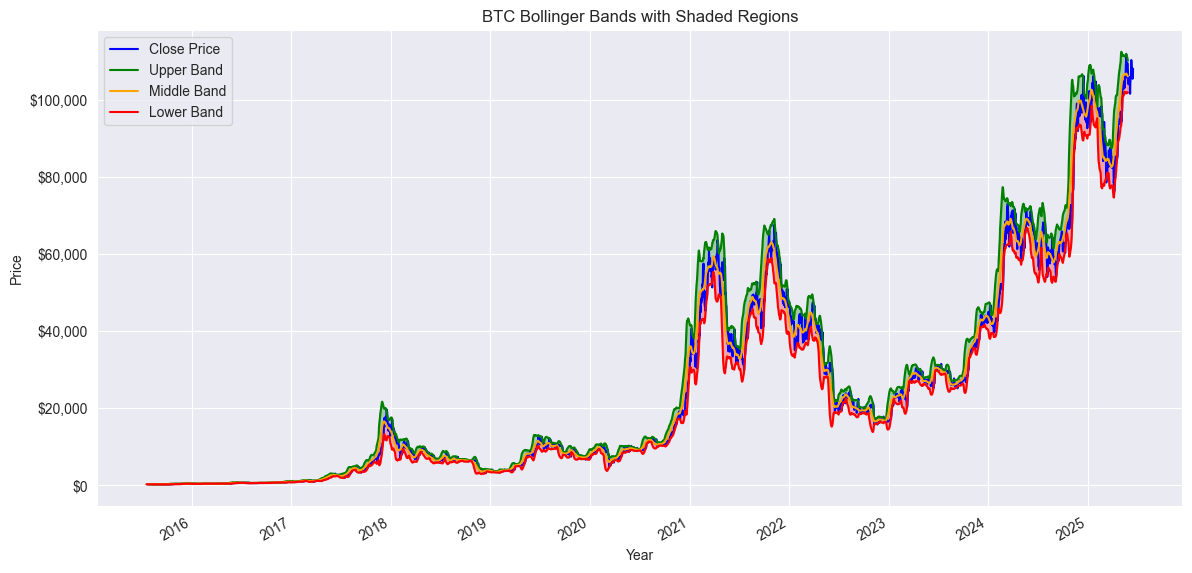

In [108]:
fig, ax = plt.subplots(figsize=(14, 7))
df['time'] = df.index

# Plot the price and Bollinger Bands
ax.plot(df['time'], df['close'], label='Close Price', color='blue')
ax.plot(df['time'], df['BB_Upper'], label='Upper Band', color='green')
ax.plot(df['time'], df['BB_Middle'], label='Middle Band', color='orange')
ax.plot(df['time'], df['BB_Lower'], label='Lower Band', color='red')

# Shade the area between the upper and middle bands
ax.fill_between(df['time'], df['BB_Upper'], df['BB_Middle'], color='green', alpha=0.3)
# Shade the area between the middle and lower bands
ax.fill_between(df['time'], df['BB_Middle'], df['BB_Lower'], color='red', alpha=0.3)

ax.set_xlabel('Year')
ax.set_ylabel('Price')
# Format y axis to show currency
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.set_title(f'{COIN} Bollinger Bands with Shaded Regions')
ax.legend()
ax.grid(True)

# Optional: improve formatting of x-axis dates
fig.autofmt_xdate()
plt.show()

df.drop('time', axis=1, inplace=True)

In [ ]:
df.to_csv(fullDataPath(coin), index=False)

## Utilize in model:


* Sentiment Metrics
  * bias
  * sentiment score
* Bollinger Mid Band
* Bias
* Close Price (low weight)
* Volatility

### Steps:



1.   Get articles about a specific coin
2.   Run sentiment analysis on news articles
3.   Calculate volatility
4.   Run LSTM model and/or NN




df.index

## Get the news articles for a particular coin

In [95]:
df.index

RangeIndex(start=0, stop=3632, step=1)